# Friction Angle Machine Learning Models

In this notebook, we train and test 8 machine learning models to predict the friction angle from soil cavity simualtions.

| **Model**                                                          | **Description**                                                                                                                                                                                     |
|-------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Linear Regression with $H$, $d$                                         | Regularized multiple linear regression fitted with two numerical values: cavity depth $H$ and soil density $d$. The regularization power $\lambda$ with $L_1$ penalty is tuned.                          |
| Linear Regression with $H$, $d$, $\sigma_r$                             | Regularized multiple linear regression fitted with vectorized stress fields $\sigma_r$ concatenated with $H$ and $d$. The regularization power $\lambda$ with $L_1$ penalty is tuned.                    |
| Fully-connected Neural Network with $\sigma_r$                          | Fully-connected two-hidden-layer neural network with vectorized stress fields $\sigma_r$. The number of hidden neurons, learning rate, and batch size are tuned.                                         |
| Fully-connected Neural Network with $H$, $d$, $\sigma_r$                | Fully-connected two-hidden-layer neural network with cavity depth $H$, soil density $d$, and vectorized stress fields $\sigma_r$. The number of hidden neurons, learning rate, and batch size are tuned. |
| Convolutional Neural Network with $\sigma_r$                            | Convolutional neural network with 6 hidden layers trained with stress field images $\sigma_r$. The learning rate and batch size are tuned.                                                               |
| Convolutional Neural Network with $H$, $d$, and $\sigma_r$              | Convolutional neural network with 6 hidden layers trained with cavity depth $H$, soil density $d$, and stress field images $\sigma_r$. The learning rate and batch size are tuned.                       |
| Convolutional Neural Network with $H$, $d$, and interpolated $\sigma_r$ | Convolutional neural network with 6 hidden layers trained with cavity depth $H$, soil density $d$, and interpolated stress field images $\sigma_r$. The learning rate and batch size are tuned.          |
| Mean-score Predictor                                                    | Predict $\phi$ using the average mean of $\phi$ scores in the training set.                                                                                                                              |

In [1]:
import numpy as np
import pandas as pd
import re
import cv2

from random import sample
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from glob import glob
from json import load, dump
from os.path import basename
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
from collections import Counter
from random import sample
from tqdm import tqdm

from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import copy
import scipy.io

RANDOM_SEED = 5012021

## 1. Linear regression with Depth + Density

### 1.1. Create Dataset

In [2]:
input_df = pd.read_csv('./data/data-12-01/Disp_Output.csv')
input_df.head()

,Folder,Depth,d,E,v,phi,psi,c,sv,sh,Delft_inf,Delft_sug,Exists,yield_angle,yield_stress,yield_strain
0,Disp_0,42,2108.58,49040300,0.292470,44.522842,14.1261,4999.998647,868.777132,259.596199,6113.901626,6089.417004,1,45.0,1371.814247,0.053224
1,Disp_1,42,2378.76,30544100,0.384267,30.984098,19.1708,4999.998860,980.096695,475.542763,4251.249310,4241.385338,1,NaN,inf,inf
2,Disp_10,26,1943.92,54098200,0.277512,31.420224,17.8703,4999.994369,495.816235,237.341833,3442.231579,3367.061231,1,NaN,inf,inf
3,Disp_100,37,2341.64,98842600,0.302208,36.306435,13.4055,4999.997057,849.945071,346.689454,6781.475357,6706.207493,1,NaN,inf,inf
4,Disp_1000,18,1794.09,51484900,0.339554,43.157792,14.0802,5000.006868,316.800412,100.105789,3325.922880,3142.177730,1,40.0,527.343236,0.022421


In [3]:
feature_df = input_df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 9, 14]]
#feature_df.loc[:, 'phi'] = np.sin(feature_df['phi'])
feature_df.loc[:, 'psi'] = np.sin(feature_df['psi'])

# Need to handle the nan cases in the last feature
max_stress = list(np.sort(list(set(feature_df['yield_stress']))))[-2] * 1.2
feature_df.loc[:, 'yield_stress'] = [x if x != np.inf else max_stress for x in
                                     feature_df['yield_stress']]

/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [4]:
feature_df

,Folder,Depth,d,E,v,phi,psi,sv,sh,yield_stress
0,Disp_0,42,2108.58,49040300,0.292470,44.522842,0.999939,868.777132,259.596199,1371.814247
1,Disp_1,42,2378.76,30544100,0.384267,30.984098,0.315747,980.096695,475.542763,12599.315984
2,Disp_10,26,1943.92,54098200,0.277512,31.420224,-0.830083,495.816235,237.341833,12599.315984
3,Disp_100,37,2341.64,98842600,0.302208,36.306435,0.744062,849.945071,346.689454,12599.315984
4,Disp_1000,18,1794.09,51484900,0.339554,43.157792,0.998378,316.800412,100.105789,527.343236
...,...,...,...,...,...,...,...,...,...,...
1495,Disp_995,22,2193.27,32543800,0.303484,22.948507,-0.482105,473.351531,288.790019,12599.315984
1496,Disp_996,23,1840.08,91644200,0.367731,32.859599,0.814962,415.177250,189.909436,1856.090156
1497,Disp_997,26,2175.94,47073400,0.380248,27.135103,-0.569548,554.995256,301.867349,12599.315984
1498,Disp_998,31,2140.87,80047000,0.340440,42.031298,-0.394053,651.059976,215.151590,12599.315984


In [5]:
# Normalize the feature dataframe
feature_df_normalized = feature_df.copy()
feature_df_normalized

feature_js = [1, 2, 3, 4, 6, 7, 8]
scaler = StandardScaler()
scaler.fit(feature_df.iloc[:, feature_js])
feature_df_normalized.iloc[:, feature_js] = scaler.transform(feature_df.iloc[:, feature_js])

feature_df_normalized.head()

,Folder,Depth,d,E,v,phi,psi,sv,sh,yield_stress
0,Disp_0,1.098729,0.500785,-0.803819,-0.805880,44.522842,1.396116,1.235756,0.080602,1371.814247
1,Disp_1,1.098729,1.668165,-1.710334,1.326171,30.984098,0.380337,1.648810,1.626524,12599.315984
2,Disp_10,-0.104479,-0.210669,-0.555927,-1.153291,31.420224,-1.320810,-0.148124,-0.078713,12599.315984
3,Disp_100,0.722727,1.507779,1.637035,-0.579708,36.306435,1.016230,1.165879,0.704087,12599.315984
4,Disp_1000,-0.706083,-0.858047,-0.684007,0.287680,43.157792,1.393799,-0.812367,-1.061161,527.343236


In [6]:
# We also load the image data to make sure that we are working on the same
# training/test dataset (just with different features)

heatmap_image_data = np.load('./data/displayment-heatmaps-normalized-resized.npz')
heatmaps_images = heatmap_image_data['rs_normalized_heatmaps']
heatmaps_ids = heatmap_image_data['heatmaps_ids']

indexes = [int(x[5:]) for x in feature_df['Folder']]

In [7]:
features = []
scores = []
df_is = []

for i in tqdm(range(len(heatmaps_ids))):
    df_i = indexes.index(heatmaps_ids[i])
    df_is.append(df_i)
    
    # Collect the features
    row = feature_df_normalized.iloc[df_i, :]
    cur_features = row[['Depth', 'd']].to_numpy().astype(float)
    features.append((heatmaps_images[i], cur_features))
    
    # Collect the y's
    scores.append(row['phi'])

features = np.array(features)
scores = np.array(scores)

100%|█████████████████████████████████████| 1363/1363 [00:00<00:00, 1689.67it/s]
/tmp/ipykernel_8360/775314705.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)


In [8]:
# Split the training/vali/test dataset

train_features, temp_features, train_scores, temp_scores = train_test_split(
    features, scores, train_size=0.6, random_state=RANDOM_SEED)
vali_features, test_features, vali_scores, test_scores = train_test_split(
    temp_features, temp_scores, train_size=0.5, random_state=RANDOM_SEED)

print(train_features.shape, train_scores.shape,
      vali_features.shape, vali_scores.shape,
      test_features.shape, test_scores.shape)

(817, 2) (817,) (273, 2) (273,) (273, 2) (273,)


In [9]:
# Collect the depth and density feature

naive_train_features = np.stack([f[1] for f in train_features], axis=0)
naive_vali_features = np.stack([f[1] for f in vali_features], axis=0)
naive_test_features = np.stack([f[1] for f in test_features], axis=0)

In [10]:
# # Grid search the regularization power over validation set (Lasso regression)

# model = linear_model.Lasso()
# params = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
# clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error')
# clf.fit(naive_train_features, train_scores)

# print(clf.cv_results_)
# print(clf.best_params_)
# print(clf.best_score_)

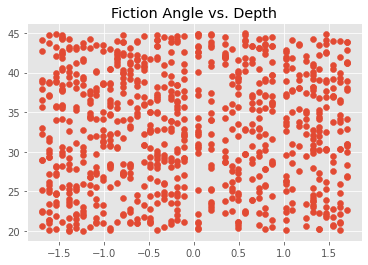

In [11]:
plt.scatter(naive_train_features[:, 0], train_scores)
plt.title('Fiction Angle vs. Depth')
plt.show()

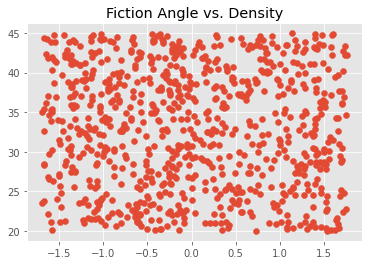

In [12]:
plt.scatter(naive_train_features[:, 1], train_scores)
plt.title('Fiction Angle vs. Density')
plt.show()

In [13]:
def eval_model_sklearn(model, x, y, title=''):
    y_predict = model.predict(x)
    
    mse = metrics.mean_squared_error(y, y_predict)
    mae = metrics.mean_absolute_error(y, y_predict)
    
    print('{}\tMSE: {:.4f}  MAE: {:.4f}'.format(title, mse, mae))
    
    return mse, mae

In [14]:
# Train the best model
best_model = linear_model.Lasso(alpha=0.001)
best_model.fit(naive_train_features, train_scores)

eval_model_sklearn(best_model, naive_train_features, train_scores, 'train')
eval_model_sklearn(best_model, naive_vali_features, vali_scores, 'vali')
eval_model_sklearn(best_model, naive_test_features, test_scores, 'test')

train	MSE: 54.3087  MAE: 6.4023
vali	MSE: 55.9063  MAE: 6.4895
test	MSE: 55.4905  MAE: 6.4782


(55.490540685578644, 6.4782056325531014)

## 2. Linear Model with Depth + Density + Simulation Output

In [61]:
p_features = []
p_scores = []

for i in tqdm(range(len(heatmaps_ids))):
    df_i = indexes.index(heatmaps_ids[i])
    
    # Collect the features
    row = feature_df_normalized.iloc[df_i, :]
    cur_features = row[['Depth', 'd']].to_numpy().astype(float)
    p_features.append((heatmaps_images[i], cur_features))
    
    # Collect the y's
    p_scores.append(input_df.iloc[df_i, :]['phi'])

p_features = np.array(p_features)
p_scores = np.array(p_scores)

100%|██████████████████████████████████████| 1363/1363 [00:01<00:00, 692.55it/s]
/tmp/ipykernel_6026/54177860.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_features = np.array(p_features)


(array([149., 132., 123., 131., 125., 133., 132., 147., 129., 162.]),
 array([20.01541543, 22.5112304 , 25.00704537, 27.50286034, 29.99867532,
        32.49449029, 34.99030526, 37.48612023, 39.9819352 , 42.47775017,
        44.97356514]),
 <BarContainer object of 10 artists>)

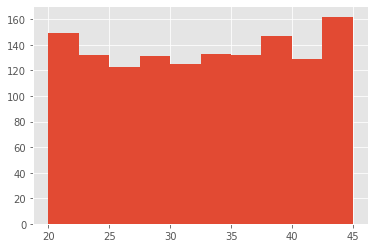

In [62]:
plt.hist(p_scores)

In [63]:
p_train_features, p_temp_features, p_train_scores, p_temp_scores = train_test_split(
    p_features, p_scores, train_size=0.6, random_state=33)
p_vali_features, p_test_features, p_vali_scores, p_test_scores = train_test_split(
    p_temp_features, p_temp_scores, train_size=0.5, random_state=33)

print(p_train_features.shape, p_train_scores.shape,
      p_vali_features.shape, p_vali_scores.shape,
      p_test_features.shape, p_test_scores.shape)

(817, 2) (817,) (273, 2) (273,) (273, 2) (273,)


In [64]:
p_train_features_linear = []
p_vali_features_linear = []
p_test_features_linear = []

for i in tqdm(range(p_train_features.shape[0])):
    cur_feature = p_train_features[i][0].reshape(-1)
    cur_feature = np.concatenate([cur_feature, p_train_features[i][1].reshape(-1)])
    
    p_train_features_linear.append(cur_feature)
    
for i in tqdm(range(p_vali_features.shape[0])):
    cur_feature = p_vali_features[i][0].reshape(-1)
    cur_feature = np.concatenate([cur_feature, p_vali_features[i][1].reshape(-1)])
    
    p_vali_features_linear.append(cur_feature)
    
for i in tqdm(range(p_test_features.shape[0])):
    cur_feature = p_test_features[i][0].reshape(-1)
    cur_feature = np.concatenate([cur_feature, p_test_features[i][1].reshape(-1)])
    
    p_test_features_linear.append(cur_feature)
    
p_train_features_linear = np.vstack(p_train_features_linear)
p_vali_features_linear = np.vstack(p_vali_features_linear)
p_test_features_linear = np.vstack(p_test_features_linear)

100%|███████████████████████████████████████| 273/273 [00:00<00:00, 3293.69it/s]


In [65]:
# Normalize the features

scaler = StandardScaler()
scaler.fit(p_train_features_linear)

p_train_features_linear_standardized = scaler.transform(p_train_features_linear)
p_vali_features_linear_standardized = scaler.transform(p_vali_features_linear)
p_test_features_linear_standardized = scaler.transform(p_test_features_linear)

In [66]:
# Grid search the regularization power over validation set (lasso regression)

# model = linear_model.Lasso()
# params = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}]
# clf = GridSearchCV(model, params, scoring='neg_mean_absolute_error')
# clf.fit(p_train_features_linear_standardized, p_train_scores)

# print(clf.cv_results_)
# print(clf.best_params_)
# print(clf.best_score_)

In [67]:
model = linear_model.Lasso(alpha=0.0001)
model.fit(p_train_features_linear_standardized, p_train_scores)

/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1123.2625520919332, tolerance: 4.464060210010406
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0001)

Print out the evaluation metrics.

In [45]:
eval_model_sklearn(model, p_train_features_linear_standardized, p_train_scores, 'train')
eval_model_sklearn(model, p_vali_features_linear_standardized, p_vali_scores, 'vali')
eval_model_sklearn(model, p_test_features_linear_standardized, p_test_scores, 'test')

train	MSE: 2.3696  MAE: 1.1710
vali	MSE: 4.0477  MAE: 1.5523
test	MSE: 3.4700  MAE: 1.4179


(3.4699889445604755, 1.417873250088553)

## 3. Fully Connected NN with Depth + Density

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [82]:
class SimpleNN(nn.Module):
    def __init__(self, feature_size):
        super(SimpleNN, self).__init__()
        
        self.feature_size = feature_size
        
        self.fc1 = nn.Linear(self.feature_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, feature):
        
        x = F.relu(self.fc1(feature))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # x = F.softmax(x, dim=1)
        return x

In [83]:
p_train_features_linear = []
p_vali_features_linear = []
p_test_features_linear = []

for i in tqdm(range(p_train_features.shape[0])):
    cur_feature = p_train_features[i][1].reshape(-1)
    
    p_train_features_linear.append(cur_feature)
    
for i in tqdm(range(p_vali_features.shape[0])):
    cur_feature = p_vali_features[i][1].reshape(-1)
    
    p_vali_features_linear.append(cur_feature)
    
for i in tqdm(range(p_test_features.shape[0])):
    cur_feature = p_test_features[i][1].reshape(-1)
    
    p_test_features_linear.append(cur_feature)
    
p_train_features_linear = np.vstack(p_train_features_linear)
p_vali_features_linear = np.vstack(p_vali_features_linear)
p_test_features_linear = np.vstack(p_test_features_linear)

100%|█████████████████████████████████████| 273/273 [00:00<00:00, 278735.39it/s]


In [84]:
model = SimpleNN(p_train_features_linear_standardized.shape[1])

feature = torch.tensor(p_train_features_linear_standardized[0, :]).float().to(device)
model = model.to(device)
model(feature)

tensor([0.0205], device='cuda:0', grad_fn=<AddBackward0>)

In [85]:
class SimulationDataset(Dataset):

    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        cur_feature = torch.tensor(self.features[idx]).float()
        label = torch.tensor([self.labels[idx]]).float()
        
        sample = {'feature': cur_feature, 'label': label}

        return sample

In [91]:
def train_one_epoch_nn(train_dataloader, epoch, print_every_ter=None, verbose=True,
                       selected_indexes=None):
    losses = []
    all_losses = []
    y_predict = []
    y_true = []
    for i, data in enumerate(train_dataloader, 0):
        cur_features, cur_labels = (data['feature'].to(device),
                                    data['label'].to(device))
        
        # Only use depth and d here
        if selected_indexes != None:
            cur_features = cur_features[:, selected_indexes]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(cur_features)
        loss = criterion(outputs, cur_labels)
        loss.backward()
        optimizer.step()
        
        y_predict.extend(outputs.tolist())
        y_true.extend(cur_labels.tolist())

        # print statistics
        losses.append(loss.item())
        
        if print_every_ter != None:
            if i % print_every_ter == print_every_ter - 1:
                print('(epoch {}, iter {}) avg loss: {:3f}'.format(epoch + 1,
                                                                   i + 1,
                                                                   np.mean(losses)))
                all_losses.extend(losses)
                losses = []
        else:
            all_losses.append(loss.item())
    
    # Evaluate the accuracy
    mse = metrics.mean_squared_error(y_true, y_predict)
    avg_loss = np.mean(all_losses)
    
    if verbose:
        print('Epoch {}: training acc: {:.4f} avg loss: {:.4f}'.format(epoch, acc, avg_loss))

    return mse, avg_loss

In [92]:
def eval_model_nn(test_dataloader, model, selected_indexes=None, title='', verbose=False):
    losses = []
    y_predict = []
    y_true = []

    for i, data in enumerate(test_dataloader, 0):
        cur_features, cur_labels = (data['feature'].to(device),
                                    data['label'].to(device))
        
        # Only use depth and d here
        if selected_indexes != None:
            cur_features = cur_features[:, selected_indexes]

        # forward + backward + optimize
        outputs = model(cur_features)
        loss = criterion(outputs, cur_labels)
        losses.append(loss.item())

        y_predict.extend(outputs.tolist())
        y_true.extend(cur_labels.tolist())
    
    mse = metrics.mean_squared_error(y_true, y_predict)
    mae = metrics.mean_absolute_error(y_true, y_predict)
    avg_loss = np.mean(losses)
    
    if verbose:
        print('{}\tMSE: {:.4f}  MAE: {:.4f}'.format(title, mse, mae))
    
    return mse, mae

In [93]:
# Normalize the features

scaler = StandardScaler()
scaler.fit(p_train_features_linear)

p_train_features_linear_standardized = scaler.transform(p_train_features_linear)
p_vali_features_linear_standardized = scaler.transform(p_vali_features_linear)
p_test_features_linear_standardized = scaler.transform(p_test_features_linear)

In [94]:
train_dataset = SimulationDataset(p_train_features_linear_standardized, p_train_scores)
vali_dataset = SimulationDataset(p_vali_features_linear_standardized, p_vali_scores)
test_dataset = SimulationDataset(p_test_features_linear_standardized, p_test_scores)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
vali_dataloader = DataLoader(vali_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

criterion = nn.MSELoss()

In [95]:
PATIENCE = 30
epochs = 150


model = SimpleNN(p_train_features_linear_standardized.shape[1]).to(device)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_mses = []
train_avg_losses = []

val_mses = []
val_avg_losses = []

best_loss = np.inf
best_mse = np.inf
waited = 0
best_model = None

for e in tqdm(range(epochs)):
    mse, avg_loss = train_one_epoch_nn(train_dataloader, e, verbose=False)
    train_mses.append(mse)
    train_avg_losses.append(avg_loss)
    
    # Test on the validation set
    val_mse, val_avg_loss = eval_model_nn(vali_dataloader, model)
    val_mses.append(val_mse)
    val_avg_losses.append(val_avg_loss)
    
    if val_mse < best_mse:
        # best_loss = val_avg_loss
        best_mse = val_mse
        waited = 0
        best_model = copy.deepcopy(model)
    else:
        waited += 1
    
    if waited == PATIENCE + 1:
        break

print('Done!')

 78%|███████████████████████████████▉         | 117/150 [00:18<00:05,  6.17it/s]

Done!


In [96]:
eval_model_nn(train_dataloader, best_model, verbose=True)

	MSE: 54.0189  MAE: 6.3725


(54.018903620913534, 6.372514267154539)

In [97]:
eval_model_nn(vali_dataloader, best_model, verbose=True)

	MSE: 56.1419  MAE: 6.5234


(56.14192799422702, 6.523375165331495)

In [98]:
eval_model_nn(test_dataloader, best_model, verbose=True)

	MSE: 55.7965  MAE: 6.5283


(55.796476332984035, 6.528306185544192)

## 4. Fully Connected NN with Depth + Density + Simulation Output

In [104]:
p_train_features_linear = []
p_vali_features_linear = []
p_test_features_linear = []

for i in tqdm(range(p_train_features.shape[0])):
    cur_feature = p_train_features[i][0].reshape(-1)
    cur_feature = np.concatenate([cur_feature, p_train_features[i][1].reshape(-1)])
    
    p_train_features_linear.append(cur_feature)
    
for i in tqdm(range(p_vali_features.shape[0])):
    cur_feature = p_vali_features[i][0].reshape(-1)
    cur_feature = np.concatenate([cur_feature, p_vali_features[i][1].reshape(-1)])
    
    p_vali_features_linear.append(cur_feature)
    
for i in tqdm(range(p_test_features.shape[0])):
    cur_feature = p_test_features[i][0].reshape(-1)
    cur_feature = np.concatenate([cur_feature, p_test_features[i][1].reshape(-1)])
    
    p_test_features_linear.append(cur_feature)
    
p_train_features_linear = np.vstack(p_train_features_linear)
p_vali_features_linear = np.vstack(p_vali_features_linear)
p_test_features_linear = np.vstack(p_test_features_linear)

100%|███████████████████████████████████████| 273/273 [00:00<00:00, 3405.59it/s]


In [106]:
# Normalize the features

scaler = StandardScaler()
scaler.fit(p_train_features_linear)

p_train_features_linear_standardized = scaler.transform(p_train_features_linear)
p_vali_features_linear_standardized = scaler.transform(p_vali_features_linear)
p_test_features_linear_standardized = scaler.transform(p_test_features_linear)

In [108]:
train_dataset = SimulationDataset(p_train_features_linear_standardized, p_train_scores)
vali_dataset = SimulationDataset(p_vali_features_linear_standardized, p_vali_scores)
test_dataset = SimulationDataset(p_test_features_linear_standardized, p_test_scores)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
vali_dataloader = DataLoader(vali_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

criterion = nn.MSELoss()

In [113]:
PATIENCE = 50
epochs = 150


model = SimpleNN(p_train_features_linear_standardized.shape[1]).to(device)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_mses = []
train_avg_losses = []

val_mses = []
val_avg_losses = []

best_loss = np.inf
best_mse = np.inf
waited = 0
best_model = None

for e in tqdm(range(epochs)):
    mse, avg_loss = train_one_epoch_nn(train_dataloader, e, verbose=False)
    train_mses.append(mse)
    train_avg_losses.append(avg_loss)
    
    # Test on the validation set
    val_mse, val_avg_loss = eval_model_nn(vali_dataloader, model)
    val_mses.append(val_mse)
    val_avg_losses.append(val_avg_loss)
    
    if val_mse < best_mse:
        # best_loss = val_avg_loss
        best_mse = val_mse
        waited = 0
        best_model = copy.deepcopy(model)
    else:
        waited += 1
    
    if waited == PATIENCE + 1:
        break

print('Done!')

100%|█████████████████████████████████████████| 150/150 [00:44<00:00,  3.39it/s]

Done!


In [114]:
eval_model_nn(train_dataloader, best_model, verbose=True)

	MSE: 0.8881  MAE: 0.6991


(0.8880625077635512, 0.6990513865775548)

In [115]:
eval_model_nn(vali_dataloader, best_model, verbose=True)

	MSE: 1.0109  MAE: 0.7809


(1.0109219650569021, 0.7808815393692408)

In [116]:
eval_model_nn(test_dataloader, best_model, verbose=True)

	MSE: 1.2035  MAE: 0.8247


(1.20346068942043, 0.8247013231773517)

## 5. CNN Model with only Simulation Images

In [151]:
class SimpleCNN(nn.Module):
    def __init__(self, additional_feature_size):
        super(SimpleCNN, self).__init__()
        self.additional_feature_size = additional_feature_size
        self.conv1 = nn.Conv2d(1, 6, 3)     
        self.conv2 = nn.Conv2d(6, 6, 3)
        self.pool1= nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(6, 6, 3)
        self.conv4 = nn.Conv2d(6, 6, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(6, 6, 3)
        self.conv6 = nn.Conv2d(6, 6, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(6 * 28 * 28 + self.additional_feature_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, image, feature):
        image = image.view(-1, 1, 256, 256)
        
        # Passing the CNN layers
        x = F.relu(self.conv1(image))
        x = self.pool1(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        
        x = F.relu(self.conv5(x))
        x = self.pool3(F.relu(self.conv6(x)))
                
        x = x.view(-1, 6 * 28 * 28)
        
        # Concatenate with extra features
        x = torch.cat((x, feature), dim=1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # x = F.softmax(x, dim=1)
        return x

In [152]:
class HeatmapDataset(Dataset):

    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        cur_feature = self.features[idx]
        # label = nn.functional.one_hot(torch.tensor(labels[idx]), num_classes=3)
        label = torch.tensor([self.labels[idx]]).float()
        
        # Load image and extra feature
        image = torch.tensor(cur_feature[0]).float()
        extra_feature = torch.tensor(cur_feature[1]).float()
        
        # Transform image
        image = image.view((1, 256, 256))
        
        sample = {'image': image, 'feature': extra_feature, 'label': label}

        return sample

In [154]:
heatmap_image_data = np.load('./data/displayment-heatmaps-normalized-resized.npz')
heatmaps_images = heatmap_image_data['rs_normalized_heatmaps']
heatmaps_ids = heatmap_image_data['heatmaps_ids']

indexes = [int(x[5:]) for x in feature_df['Folder']]

features = []
labels = []

for i in tqdm(range(len(heatmaps_ids))):
    df_i = indexes.index(heatmaps_ids[i])
    
    # Collect the features
    row = feature_df_normalized.iloc[df_i, :]
    cur_features = row[['Depth', 'd']].to_numpy().astype(float)
    features.append((heatmaps_images[i], cur_features))        
    labels.append(row['phi'])

features = np.array(features)
labels = np.array(labels)

100%|██████████| 1363/1363 [00:00<00:00, 1592.57it/s]
/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [156]:
model = SimpleCNN(2)
image = torch.tensor([features[0][0]]).float()
feature = torch.tensor([features[0][1]]).float()
model(image, feature)

tensor([[-0.0850]], grad_fn=<AddmmBackward>)

In [157]:
train_features, temp_features, train_scores, temp_scores = train_test_split(
    features, scores, train_size=0.6, random_state=RANDOM_SEED)
vali_features, test_features, vali_scores, test_scores = train_test_split(
    temp_features, temp_scores, train_size=0.5, random_state=RANDOM_SEED)

print(train_features.shape, train_scores.shape,
      vali_features.shape, vali_scores.shape,
      test_features.shape, test_scores.shape)

(817, 2) (817,) (273, 2) (273,) (273, 2) (273,)


In [185]:
train_dataset = HeatmapDataset(train_features, train_scores)
vali_dataset = HeatmapDataset(vali_features, vali_scores)
test_dataset = HeatmapDataset(test_features, test_scores)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
vali_dataloader = DataLoader(vali_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [186]:
def train_one_epoch(train_dataloader, epoch, print_every_ter=None, verbose=True,
                   selected_indexes=None):
    losses = []
    all_losses = []
    y_predict = []
    y_true = []
    for i, data in enumerate(train_dataloader, 0):
        cur_images, cur_features, cur_labels = (data['image'].to(device),
                                                data['feature'].to(device),
                                                data['label'].to(device))
        
        # Only use depth and d here
        if selected_indexes != None:
            cur_features = cur_features[:, selected_indexes]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(cur_images, cur_features)
        loss = criterion(outputs, cur_labels)
        loss.backward()
        optimizer.step()
        
        y_predict.extend(outputs.tolist())
        y_true.extend(cur_labels.tolist())

        # print statistics
        losses.append(loss.item())
        
        if print_every_ter != None:
            if i % print_every_ter == print_every_ter - 1:
                print('(epoch {}, iter {}) avg loss: {:3f}'.format(epoch + 1,
                                                                   i + 1,
                                                                   np.mean(losses)))
                all_losses.extend(losses)
                losses = []
        else:
            all_losses.append(loss.item())
    
    # Evaluate the accuracy
    mse = metrics.mean_squared_error(y_true, y_predict)
    avg_loss = np.mean(all_losses)
    
    if verbose:
        print('Epoch {}: training acc: {:.4f} avg loss: {:.4f}'.format(epoch, acc, avg_loss))

    return mse, avg_loss

In [187]:
def eval_model(test_dataloader, model, selected_indexes=None, verbose=False, title=''):
    losses = []
    y_predict = []
    y_true = []

    for i, data in enumerate(test_dataloader, 0):
        cur_images, cur_features, cur_labels = (data['image'].to(device),
                                                data['feature'].to(device),
                                                data['label'].to(device))
        
        # Only use depth and d here
        if selected_indexes != None:
            cur_features = cur_features[:, selected_indexes]

        # forward + backward + optimize
        outputs = model(cur_images, cur_features)
        loss = criterion(outputs, cur_labels)
        losses.append(loss.item())

        y_predict.extend(outputs.tolist())
        y_true.extend(cur_labels.tolist())
    
    mse = metrics.mean_squared_error(y_true, y_predict)
    mae = metrics.mean_absolute_error(y_true, y_predict)
    avg_loss = np.mean(losses)
    
    if verbose:
        print('{}\tMSE: {:.4f}  MAE: {:.4f}'.format(title, mse, mae))
    
    return mse, mae
    

In [204]:
PATIENCE = 400
epochs = 400

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

selected_indexes = []

model = SimpleCNN(len(selected_indexes)).to(device)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_mses = []
train_avg_losses = []

val_mses = []
val_avg_losses = []

best_loss = np.inf
best_mse = np.inf
waited = 0
best_model = None

for e in tqdm(range(epochs)):
    mse, avg_loss = train_one_epoch(train_dataloader, e, verbose=False,
                                    selected_indexes=selected_indexes)
    train_mses.append(mse)
    train_avg_losses.append(avg_loss)
    
    # Test on the validation set
    val_mse, val_avg_loss = eval_model(vali_dataloader, model,
                                       selected_indexes=selected_indexes)
    val_mses.append(val_mse)
    val_avg_losses.append(val_avg_loss)
    
    if val_mse < best_mse:
        # best_loss = val_avg_loss
        best_mse = val_mse
        waited = 0
        best_model = copy.deepcopy(model)
    else:
        waited += 1
    
    if waited == PATIENCE + 1:
        break

print('Done!')

  0%|          | 0/400 [00:00<?, ?it/s]

Using device: cuda


100%|██████████| 400/400 [06:59<00:00,  1.05s/it]

Done!


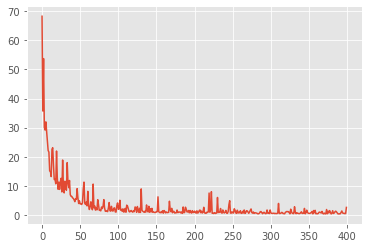

In [205]:
plt.plot(val_mses)
plt.show()

In [207]:
selected_indexes = []
eval_model(train_dataloader, best_model, selected_indexes=selected_indexes,
           verbose=True, title='train')

eval_model(vali_dataloader, best_model, selected_indexes=selected_indexes,
           verbose=True, title='vali')

eval_model(test_dataloader, best_model, selected_indexes=selected_indexes,
           verbose=True, title='test')

train	MSE: 0.2808  MAE: 0.3888
vali	MSE: 0.3512  MAE: 0.4440
test	MSE: 0.5284  MAE: 0.5035


(0.5283550406823122, 0.503521231067923)

## 6. CNN Model with Simulation Image + Depth + Density

In [192]:
PATIENCE = 400
epochs = 400

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

selected_indexes = [0, 1]

model = SimpleCNN(len(selected_indexes)).to(device)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_mses = []
train_avg_losses = []

val_mses = []
val_avg_losses = []

best_loss = np.inf
best_mse = np.inf
waited = 0
best_model = None

for e in tqdm(range(epochs)):
    mse, avg_loss = train_one_epoch(train_dataloader, e, verbose=False,
                                    selected_indexes=selected_indexes)
    train_mses.append(mse)
    train_avg_losses.append(avg_loss)
    
    # Test on the validation set
    val_mse, val_avg_loss = eval_model(vali_dataloader, model,
                                       selected_indexes=selected_indexes)
    val_mses.append(val_mse)
    val_avg_losses.append(val_avg_loss)
    
    if val_mse < best_mse:
        # best_loss = val_avg_loss
        best_mse = val_mse
        waited = 0
        best_model = copy.deepcopy(model)
    else:
        waited += 1
    
    if waited == PATIENCE + 1:
        break

print('Done!')

  0%|          | 0/400 [00:00<?, ?it/s]

Using device: cuda


100%|██████████| 400/400 [07:05<00:00,  1.06s/it]

Done!


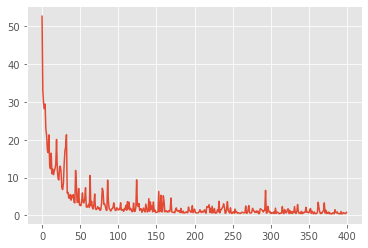

In [193]:
plt.plot(val_mses)
plt.show()

In [194]:
selected_indexes = [0, 1]
eval_model(train_dataloader, best_model, selected_indexes=selected_indexes,
           verbose=True, title='train')

eval_model(vali_dataloader, best_model, selected_indexes=selected_indexes,
           verbose=True, title='vali')

eval_model(test_dataloader, best_model, selected_indexes=selected_indexes,
           verbose=True, title='test')

train	MSE: 0.2404  MAE: 0.3760
vali	MSE: 0.3715  MAE: 0.4577
test	MSE: 0.4287  MAE: 0.4910


(0.4287498785346236, 0.4910014295752669)

## 7. CNN Model with Interpolated Simulation Image + Depth + Density

In [117]:
new_heatmap_image_data = np.load('./data/special-normalized-displayment-heatmaps.npz')
new_heatmaps_images = new_heatmap_image_data['rs_normalized_heatmaps']
new_heatmaps_ids = new_heatmap_image_data['heatmaps_ids']

In [222]:
heatmaps_ids

array([ 799,  941,  955, ...,  958, 1186,  780])

In [223]:
new_heatmaps_ids

array([ 753, 1465,  231, ...,  186, 1143, 1012])

In [225]:
new_heatmaps_images.shape

(1363, 256, 256)

Need to re-order the `new_heatmaps` to match the previous order.

In [231]:
new_heatmaps_images_ordered = [None for i in range(new_heatmaps_images.shape[0])]
new_heatmaps_ids_ordered = [None for i in range(new_heatmaps_images.shape[0])]

for i in range(len(heatmaps_ids)):
    cur_index = new_heatmaps_ids.tolist().index(heatmaps_ids[i])
    new_heatmaps_images_ordered[i] = new_heatmaps_images[cur_index]
    new_heatmaps_ids_ordered[i] = new_heatmaps_ids[cur_index]
    
new_heatmaps_images_ordered = np.array(new_heatmaps_images_ordered)
new_heatmaps_ids_ordered = np.array(new_heatmaps_ids_ordered)

In [232]:
new_heatmaps_ids_ordered

array([ 799,  941,  955, ...,  958, 1186,  780])

In [234]:
features = []
scores = []

for i in tqdm(range(len(new_heatmaps_ids_ordered))):
    df_i = indexes.index(new_heatmaps_ids_ordered[i])
    
    # Collect the features
    row = feature_df_normalized.iloc[df_i, :]
    cur_features = row[['Depth', 'd']].to_numpy().astype(float)
    features.append((new_heatmaps_images_ordered[i], cur_features))
    
    # Collect the y's
    scores.append(row['phi'])

features = np.array(features)
scores = np.array(scores)

100%|██████████| 1363/1363 [00:00<00:00, 1523.80it/s]
/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


In [235]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [236]:
class SimpleCNN(nn.Module):
    def __init__(self, additional_feature_size):
        super(SimpleCNN, self).__init__()
        self.additional_feature_size = additional_feature_size
        self.conv1 = nn.Conv2d(1, 6, 3)     
        self.conv2 = nn.Conv2d(6, 6, 3)
        self.pool1= nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(6, 6, 3)
        self.conv4 = nn.Conv2d(6, 6, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(6, 6, 3)
        self.conv6 = nn.Conv2d(6, 6, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(6 * 28 * 28 + self.additional_feature_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, image, feature):
        image = image.view(-1, 1, 256, 256)
        
        # Passing the CNN layers
        x = F.relu(self.conv1(image))
        x = self.pool1(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        
        x = F.relu(self.conv5(x))
        x = self.pool3(F.relu(self.conv6(x)))
                
        x = x.view(-1, 6 * 28 * 28)
        
        # Concatenate with extra features
        x = torch.cat((x, feature), dim=1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # x = F.softmax(x, dim=1)
        return x

In [237]:
model = SimpleCNN(2)
image = torch.tensor([features[0][0]]).float().to(device)
feature = torch.tensor([features[0][1]]).float().to(device)[:, :]
model = model.to(device)
model(image, feature)

tensor([[0.0215]], device='cuda:0', grad_fn=<AddmmBackward>)

In [238]:
features[0][0].shape

(256, 256)

In [239]:
class HeatmapDataset(Dataset):

    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        cur_feature = self.features[idx]
        # label = nn.functional.one_hot(torch.tensor(labels[idx]), num_classes=3)
        label = torch.tensor([self.labels[idx]]).float()
        
        # Load image and extra feature
        image = torch.tensor(cur_feature[0]).float()
        extra_feature = torch.tensor(cur_feature[1]).float()
        
        # Transform image
        image = image.view((1, 500, 500))
        
        sample = {'image': image, 'feature': extra_feature, 'label': label}

        return sample

In [240]:
train_features, temp_features, train_scores, temp_scores = train_test_split(
    features, scores, train_size=0.6, random_state=RANDOM_SEED)
vali_features, test_features, vali_scores, test_scores = train_test_split(
    temp_features, temp_scores, train_size=0.5, random_state=RANDOM_SEED)

print(train_features.shape, train_scores.shape,
      vali_features.shape, vali_scores.shape,
      test_features.shape, test_scores.shape)

(817, 2) (817,) (273, 2) (273,) (273, 2) (273,)


In [242]:
PATIENCE = 400
epochs = 400

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

selected_indexes = [0, 1]

model = SimpleCNN(len(selected_indexes)).to(device)

criterion = nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_mses = []
train_avg_losses = []

val_mses = []
val_avg_losses = []

best_loss = np.inf
best_mse = np.inf
waited = 0
best_model = None

for e in tqdm(range(epochs)):
    mse, avg_loss = train_one_epoch(train_dataloader, e, verbose=False,
                                    selected_indexes=selected_indexes)
    train_mses.append(mse)
    train_avg_losses.append(avg_loss)
    
    # Test on the validation set
    val_mse, val_avg_loss = eval_model(vali_dataloader, model,
                                       selected_indexes=selected_indexes)
    val_mses.append(val_mse)
    val_avg_losses.append(val_avg_loss)
    
    if val_mse < best_mse:
        # best_loss = val_avg_loss
        best_mse = val_mse
        waited = 0
        best_model = copy.deepcopy(model)
    else:
        waited += 1
    
    if waited == PATIENCE + 1:
        break

print('Done!')

  0%|          | 0/400 [00:00<?, ?it/s]

Using device: cuda


100%|██████████| 400/400 [07:33<00:00,  1.13s/it]

Done!


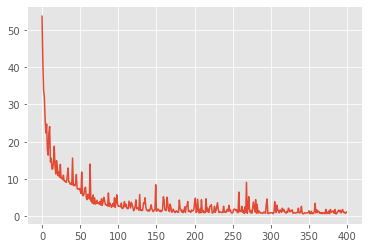

In [243]:
plt.plot(val_mses)
plt.show()

In [244]:
selected_indexes = [0, 1]
eval_model(train_dataloader, best_model, selected_indexes=selected_indexes,
           verbose=True, title='train')

eval_model(vali_dataloader, best_model, selected_indexes=selected_indexes,
           verbose=True, title='vali')

eval_model(test_dataloader, best_model, selected_indexes=selected_indexes,
           verbose=True, title='test')

train	MSE: 0.3317  MAE: 0.4495
vali	MSE: 0.6798  MAE: 0.5917
test	MSE: 0.6431  MAE: 0.6050


(0.643094870776562, 0.6050311147948324)

## 8. Naive Baseline Model

Finally, we can "train" a naive baseline model that uses the average values in the training set for all predictions.

In [118]:
train_scores.shape

(817,)

In [119]:
vali_scores.shape

(273,)

In [120]:
test_scores.shape

(273,)

In [121]:
train_predicts = np.random.uniform(np.min(train_scores), np.max(train_scores), len(train_scores))

train_predicts = np.ones(len(train_scores)) * np.mean(train_scores)

mse = metrics.mean_squared_error(train_scores, train_predicts)
mae = metrics.mean_absolute_error(train_scores, train_predicts)

print('{}\tMSE: {:.4f}  MAE: {:.4f}'.format('train', mse, mae))

train	MSE: 54.4796  MAE: 6.4217


In [122]:
train_predicts = np.random.uniform(np.min(train_scores), np.max(train_scores), len(vali_scores))

train_predicts = np.ones(len(vali_scores)) * np.mean(train_scores)

mse = metrics.mean_squared_error(vali_scores, train_predicts)
mae = metrics.mean_absolute_error(vali_scores, train_predicts)

print('{}\tMSE: {:.4f}  MAE: {:.4f}'.format('vali', mse, mae))

vali	MSE: 55.7437  MAE: 6.4772


In [123]:
train_predicts = np.random.uniform(np.min(train_scores), np.max(train_scores), len(test_scores))

train_predicts = np.ones(len(test_scores)) * np.mean(train_scores)

mse = metrics.mean_squared_error(test_scores, train_predicts)
mae = metrics.mean_absolute_error(test_scores, train_predicts)

print('{}\tMSE: {:.4f}  MAE: {:.4f}'.format('test', mse, mae))

test	MSE: 55.3257  MAE: 6.4636
